In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import layers
import random

In [2]:
trh = 0.8

In [3]:
'''gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices([], 'CPU') # hide the CPU
tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()'''


"gpus = tf.config.experimental.list_physical_devices('GPU')\nprint(gpus)\ntf.config.set_visible_devices([], 'CPU') # hide the CPU\ntf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU\ntf.config.get_visible_devices()"

In [4]:
(trainX, trainy), (testX, testy) = mnist.load_data()

In [5]:
trainX.shape

(60000, 28, 28)

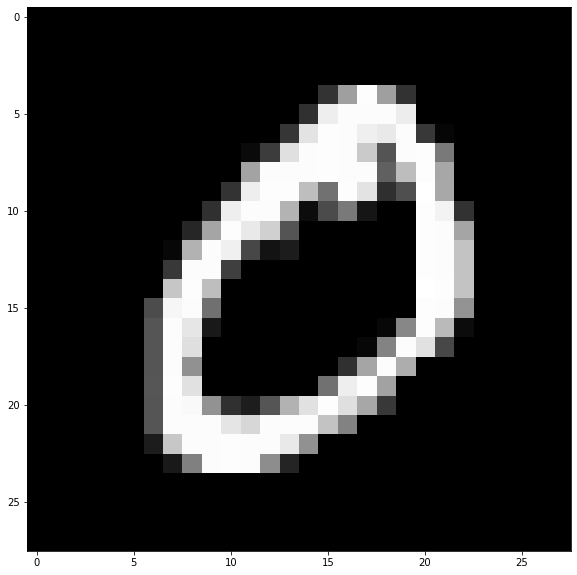

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(trainX[1], cmap=plt.get_cmap('gray'))
plt.show()

In [7]:
trainX[1][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [8]:
trainX = (trainX - 127.5)/ 127.5
testX = (testX - 127.5)/ 127.5

In [9]:
h_list = list()

In [10]:
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
    X, y = dataset
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
        # get all images for this class
        X_with_class = X[y == i]
        # choose random instances
        ix = np.random.randint(0, len(X_with_class), n_per_class)
        # add to list
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    return np.asarray(X_list), np.asarray(y_list)

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Activation('softmax'))

    return model


In [12]:
sign_trainX, sign_trainy = select_supervised_samples((trainX, trainy), n_samples=1000)

In [13]:
#sign_trainX = sign_trainX.reshape(sign_trainX.shape[0], 28, 28, 1)
#sign_trainy = sign_trainy.reshape(sign_trainy.shape[0], 1)

In [14]:
sign_trainy.shape

(1000,)

In [15]:
sign_trainX.shape

(1000, 28, 28)

In [16]:
s_train = tf.data.Dataset.from_tensor_slices((sign_trainX, sign_trainy)).shuffle(10000).batch(1024)

In [17]:
model = make_discriminator_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
history = model.fit(s_train, epochs=10, validation_data=(testX, testy))

h_list.append(history)

Epoch 1/10


C:\Users\da4nik\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 7s 7s/step - loss: 2.2999 - accuracy: 0.1290 - val_loss: 2.1376 - val_accuracy: 0.3063
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.1461 - accuracy: 0.2920 - val_loss: 1.8618 - val_accuracy: 0.5260
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.8905 - accuracy: 0.4640 - val_loss: 1.6261 - val_accuracy: 0.6055
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.6245 - accuracy: 0.5880 - val_loss: 1.3189 - val_accuracy: 0.6941
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.3551 - accuracy: 0.6530 - val_loss: 1.0401 - val_accuracy: 0.7419
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.0435 - accuracy: 0.7540 - val_loss: 0.9229 - val_accuracy: 0.7202
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.9056 - accuracy: 0.7270 - val_loss: 0.7335 - val_accuracy: 0.7747
Epoch 8/10
1/1 [==============================] - 1s

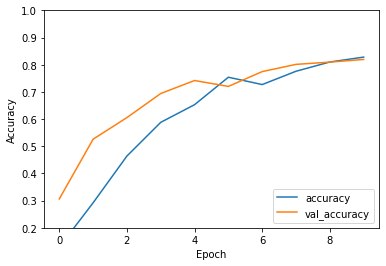

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [20]:
output = model.predict(trainX)

In [21]:
output[0]

array([2.6088490e-03, 5.8408339e-05, 1.4149088e-03, 7.3116519e-02,
       1.6237685e-05, 9.1611671e-01, 7.5996452e-04, 3.2577431e-03,
       1.3592370e-03, 1.2914198e-03], dtype=float32)

In [22]:
data = np.where(output > trh)

In [23]:
new_x = trainX[data[0]]
new_y = data[1]
trainX = np.delete(trainX, data[0], axis=0)

In [24]:
new_x = np.concatenate((new_x, sign_trainX))
new_y = np.concatenate((new_y, sign_trainy))

In [25]:
new_x.shape

(36414, 28, 28)

In [26]:
new_y.shape

(36414,)

In [27]:
trainX.shape

(24586, 28, 28)

In [28]:
i = new_y.shape[0]
while i < 52000:
    train_data = tf.data.Dataset.from_tensor_slices((new_x, new_y)).shuffle(10000).batch(1024)
    with tf.device("/gpu:0"):
        history = model.fit(train_data, epochs=10, 
                    validation_data=(testX, testy))
    h_list.append(history)
    output = model.predict(trainX)
    data = np.where(output > trh)
    new_x = np.concatenate((trainX[data[0]], new_x))
    new_y = np.concatenate((data[1], new_y))
    trainX = np.delete(trainX, data[0], axis=0)
    i = new_y.shape[0]

Epoch 1/10
36/36 [==============================] - 4s 98ms/step - loss: 0.0309 - accuracy: 0.9952 - val_loss: 0.7792 - val_accuracy: 0.8637
Epoch 2/10
36/36 [==============================] - 3s 90ms/step - loss: 0.0158 - accuracy: 0.9964 - val_loss: 0.6420 - val_accuracy: 0.8728
Epoch 3/10
36/36 [==============================] - 3s 90ms/step - loss: 0.0142 - accuracy: 0.9968 - val_loss: 0.5677 - val_accuracy: 0.8819
Epoch 4/10
36/36 [==============================] - 3s 90ms/step - loss: 0.0142 - accuracy: 0.9965 - val_loss: 0.5509 - val_accuracy: 0.8827
Epoch 5/10
36/36 [==============================] - 3s 91ms/step - loss: 0.0130 - accuracy: 0.9966 - val_loss: 0.7109 - val_accuracy: 0.8527
Epoch 6/10
36/36 [==============================] - 3s 91ms/step - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.5669 - val_accuracy: 0.8818
Epoch 7/10
36/36 [==============================] - 3s 92ms/step - loss: 0.0107 - accuracy: 0.9971 - val_loss: 0.5987 - val_accuracy: 0.8834
Epoch 8/10
36

In [29]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
def GetDataMean(hist, key):
    output_x = list()
    
    for data in hist:
        output_x.extend(data.history[key])
    
    return np.array(output_x)

In [31]:
GetDataMean(h_list, 'val_accuracy')

array([0.30630001, 0.52600002, 0.60549998, 0.69410002, 0.74190003,
       0.7202    , 0.77469999, 0.80129999, 0.8096    , 0.81940001,
       0.86369997, 0.87279999, 0.88190001, 0.88270003, 0.8527    ,
       0.8818    , 0.88340002, 0.88389999, 0.88330001, 0.88630003])

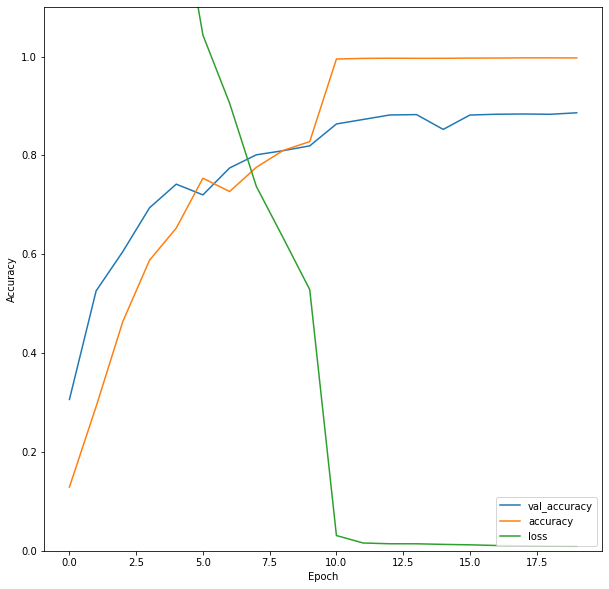

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(GetDataMean(h_list, 'val_accuracy'), label='val_accuracy')
plt.plot(GetDataMean(h_list, 'accuracy'), label='accuracy')
plt.plot(GetDataMean(h_list, 'loss'), label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.legend(loc='lower right')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0